In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import os

# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.maps import Map

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    TemplateSpatialModel,
    ConstantSpectralModel,
    PowerLawNormSpectralModel,
)

In [3]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/sokolenko/opt/anaconda3/bin/python 
	python_version         : 3.9.13     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.0        
	path                   : /Users/sokolenko/opt/anaconda3/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.21.5     
	scipy                  : 1.7.3      
	astropy                : 5.1        
	regions                : 0.7        
	click                  : 8.0.4      
	yaml                   : 6.0        
	IPython                : 7.31.1     
	jupyterlab             : 3.4.4      
	matplotlib             : 3.5.2      
	pandas                 : 1.4.4      
	healpy                 : 1.16.1     
	iminuit                : 2.8.4      
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not installed 


Gammapy enviro

In [4]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)

geom = RegionGeom.create("icrs;circle(0, 0.5, 0.1)", axes=[energy_axis])

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)


In [5]:
filename = "allenergies_TeV.fits"
m = Map.read(filename)
m = m.copy(unit="1 / (cm2 TeV s sr)")

spatial_model = TemplateSpatialModel(m, filename=filename, normalize=False)

Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(index=0, norm=1), spatial_model=spatial_model, name="Geminga-template-model")

models = Models([Geminga_model])

In [6]:
# irfs = load_cta_irfs(
#     "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
# )

irfs = load_cta_irfs(
     "/Users/sokolenko/Dropbox/CTA-Performance-prod5-v0.1-South-60deg.FITS/Prod5-South-60deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits"
)

location = observatory_locations["cta_south"]
pointing = SkyCoord("0 deg", "0 deg")
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime="5 h", location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset = spectrum_maker.run(empty_dataset, obs)

In [7]:
dataset.models = models
dataset.fake()

print(dataset)

SpectrumDataset
---------------

  Name                            : WnIiJUdh 

  Total counts                    : 213 
  Total background counts         : 216.82
  Total excess counts             : -3.82

  Predicted counts                : 216.82
  Predicted background counts     : 216.82
  Predicted excess counts         : 0.00

  Exposure min                    : 1.86e+05 m2 s
  Exposure max                    : 8.05e+10 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -939.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: SkyModel
  
    Name                      : Geminga-template-model
    Datasets names            : None
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model type       : 
    Parameters:
  

In [8]:
containment = 0.68

# correct exposure
dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
dataset.background *= factor.value.reshape((-1, 1, 1))

In [9]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

In [10]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, n_sigma=3, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

/Users/sokolenko/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,inf,5,0,gamma
0.0503641,inf,5,0,gamma
0.0711412,inf,5,0,gamma
0.10049,inf,5,0,gamma
0.141945,inf,5,3.15436e-08,gamma
0.200503,1.49221e-10,42.8594,153.922,significance
0.283218,3.67474e-12,30.8578,76.6645,significance
0.400056,1.77025e-12,37.6317,116.991,significance


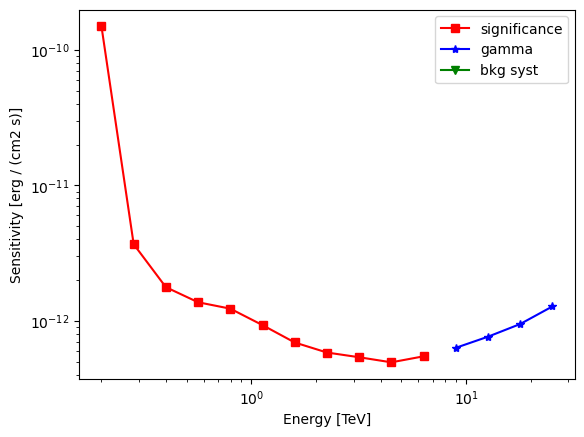

In [11]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()
